# Interannual variability and seasonality in NMEG sites

In [26]:
import sys

# laptop
sys.path.append( '/home/greg/current/NMEG_utils/py_modules/' )
# UNM desktop
#sys.path.append( '..\\NMEG_utils\\py_modules\\' )
#af_path = 'C:\\Research_Flux_Towers\\Ameriflux_files\\'
#fig_path = 'figures\\multiyear_figs\\'

import load_nmeg as ld
import transform_nmeg as tr
import plot_nmeg as nmegplt
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pdb as pdb
#import ipdb as ipdb

%matplotlib inline
sns.set_style("white")

In [28]:
data_path = '~/data/current/NMEG_utils/processed_data/daily_aflx/'
fig_path = '../figures/multiyear_figs/'
# Years to load
start = 2007
end = 2015
# Sites to load (pulls list of AF sites from plot_nmeg module)
sites = ['Seg', 'Ses', 'Wjs', 'Mpj','Vcp', 'Vcm']
# Fill a dict with multiyear dataframes for each site in sites
daily = { x : 
         ld.load_local_daily_file( data_path + 'US-' + x + '_daily_aflx.csv')
         for x in sites }
d = pd.Panel(daily)

Parsing ~/data/current/NMEG_utils/processed_data/daily_aflx/US-Seg_daily_aflx.csv
Parsing ~/data/current/NMEG_utils/processed_data/daily_aflx/US-Ses_daily_aflx.csv
Parsing ~/data/current/NMEG_utils/processed_data/daily_aflx/US-Wjs_daily_aflx.csv
Parsing ~/data/current/NMEG_utils/processed_data/daily_aflx/US-Mpj_daily_aflx.csv
Parsing ~/data/current/NMEG_utils/processed_data/daily_aflx/US-Vcp_daily_aflx.csv
Parsing ~/data/current/NMEG_utils/processed_data/daily_aflx/US-Vcm_daily_aflx.csv


In [29]:
# Function for extracting multiyear statistics on a daily scale
import math
def add_rollsum( clim ):
    # Create dataframes to hold raw year data and climatology calculations
    raw_years = pd.DataFrame( index = range( 1, 367 ))
    sum_30day = pd.DataFrame( index = range( 1, 367 ))
    rollsum = ser.rolling(window=30, center=False).sum()
    clim_sum = clim.copy()
    # Put 1 day values for each year in a column
    for i in np.unique(ser.index.year):
        year_vals = ser[ ser.index.year==i ].values
        year_vals_sum = rollsum[ rollsum.index.year==i ].values
        raw_years[ str(i) ] = np.nan
        raw_years[ str(i) ][ 0:len(year_vals)] = year_vals
        sum_30day[ str(i) ] = np.nan
        sum_30day[ str(i) ][ 0:len(year_vals_sum)] = year_vals_sum
    # Get summary stats each day of the year
    clim_sum[ 'allyr_mean' ] = raw_years.mean(axis=1)
    clim_sum[ 'allyr_stdev' ] = raw_years.std(axis=1)
    clim_sum[ 'allyr_stderr' ] = clim_sum.allyr_stdev / math.sqrt( len(np.unique(ser.index.year))-1 )
    clim_sum[ 'allyr_cv' ] = clim_sum.allyr_stdev / clim_sum.allyr_mean
    clim_sum[ 'allyr_cv2' ] = clim_sum.allyr_stdev / ser.mean()
    clim_sum[ '30day_sum' ] = sum_30day.mean(axis=1)
    clim_sum[ '30day_sum_std' ] = sum_30day.std(axis=1)
    return clim_sum

In [30]:
# Plot definition for a 3 x 2 plot of multiyear mean data
def plot_multiyr_mean_sites( clim_in, clim_cols, varname, texty, fighandle, errcol=None,
                            xlims=[0,366], ylims=[-10,10], sitelist=sites,
                            sitenames=nmegplt.longnames, colors=nmegplt.palette ):
    if type(clim_in) is list:
        clim = clim_in[0]
        clim2 = clim_in[1]
    else:
        clim = clim_in
        
    ax = list();
    for i, site in enumerate(sitelist):
        ax.append(fighandle.add_subplot(3, 2, i+1))
        plt.plot( xlims, [0, 0], ':k')
        ax[i].plot(clim[site].index, clim[site][clim_cols], color=colors[site], lw=1)
        if errcol is not None:
            ax[i].plot(clim[site].index, clim[site][clim_cols]+clim[site][errcol], 
                       color='0.6', lw=0.5)
            ax[i].plot(clim[site].index, clim[site][clim_cols]-clim[site][errcol], 
                       color='0.6', lw=0.5)
        if type(clim_in) is list:
            ax[i].plot(clim2[site].index, -clim2[site][clim_cols], color=colors[site], lw=1)
            if errcol is not None:
                ax[i].plot(clim2[site].index, -clim2[site][clim_cols]+clim2[site][errcol], 
                           color='0.6', lw=0.5)
                ax[i].plot(clim2[site].index, -clim2[site][clim_cols]-clim2[site][errcol], 
                           color='0.6', lw=0.5)
            
        plt.ylim( ylims )
        plt.xlim( xlims )
        plt.text( 10, texty, sitenames[site], size=14  )
        plt.setp( ax[i].get_yticklabels(), fontsize=13)
        #ax[i].yaxis.set_ticks(np.arange(-8, 6, 4))
        if i < 4:
            plt.setp( ax[i].get_xticklabels(), visible=False)
        else:
            plt.setp( ax[i].get_xticklabels(), fontsize=14)
            
    for i in (0, 2, 4):
        ax[i].set_ylabel(varname + '\n$g\ C\ m^2$', fontsize=14)
        
    return ax

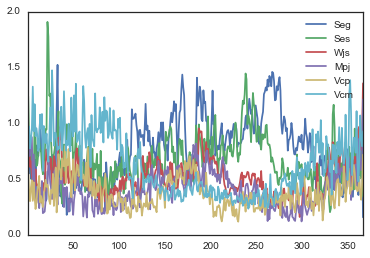

In [31]:
fc_clim, fc_clim_adj, gpp_clim, re_clim, p_clim, vpd_clim = dict(), dict(), dict(), dict(), dict(), dict()

for site in sites:
    fc_clim[ site ] = tr.var_climatology( d[ site ]['FC_F_g_int' ] )
    fc_clim_adj[ site ] = tr.var_climatology( d[ site ]['FC_F_g_int' ] + np.abs(d[ site ]['FC_F_g_int' ].min()))
    gpp_clim[ site ] = tr.var_climatology( d[ site ][ 'GPP_g_int' ] )
    re_clim[ site ] = tr.var_climatology( d[ site ][ 'RECO_g_int' ] )
    p_clim[ site ] = tr.var_climatology( d[ site ][ 'P_F_sum' ] )
    vpd_clim[ site ] = tr.var_climatology( d[ site ][ 'VPD_F_avg' ] )
    gpp_clim[site].allyr_cv.plot()
    #re_clim[site].allyr_cv.rolling(window=30, center=True).mean().plot()
plt.legend(sites)

## Plot means and standard deviation

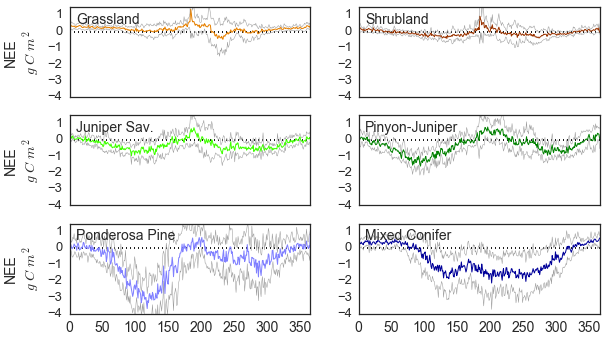

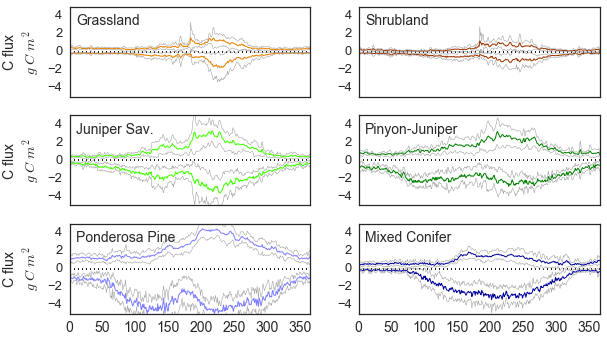

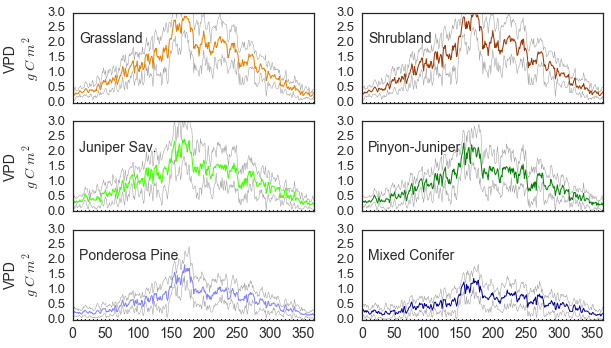

In [32]:
ylims = [ -4, 1.5 ]
xlims = [ 0, 366 ]
#highlight_year = [2011]
fig1 = plt.figure(figsize=( 9.5, 5.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_multiyr_mean_sites( fc_clim, 'allyr_mean', 'NEE', 0.5, fig1, errcol='allyr_stdev',
                        ylims=ylims)
ylims = [ -5, 5 ]
fig2 = plt.figure(figsize=( 9.5, 5.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_multiyr_mean_sites( [re_clim, gpp_clim], 'allyr_mean', 'C flux', 3, fig2, errcol='allyr_stdev',
                        ylims=ylims)
ylims = [ 0, 3 ]
fig3 = plt.figure(figsize=( 9.5, 5.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_multiyr_mean_sites( vpd_clim, 'allyr_mean', 'VPD', 2, fig3, errcol='allyr_stdev',
                        ylims=ylims)
#ylims = [ 0, 130 ]
#fig4 = plt.figure(figsize=( 9.5, 5.5 ), dpi=150, facecolor='w', edgecolor='k')
#plot_multiyr_mean_sites( p_clim, '30day_sum', '30d precip', 2, fig4, errcol='30day_sum_std',
#                        ylims=ylims)

## Plot coefficient of variation

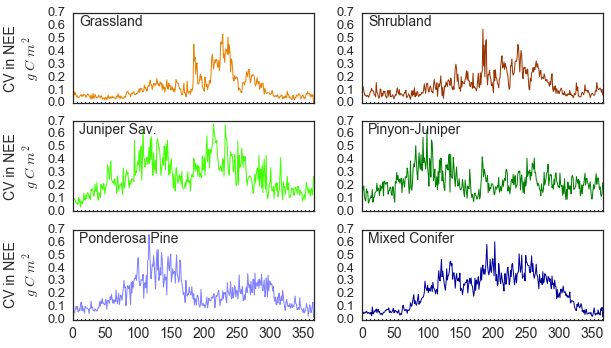

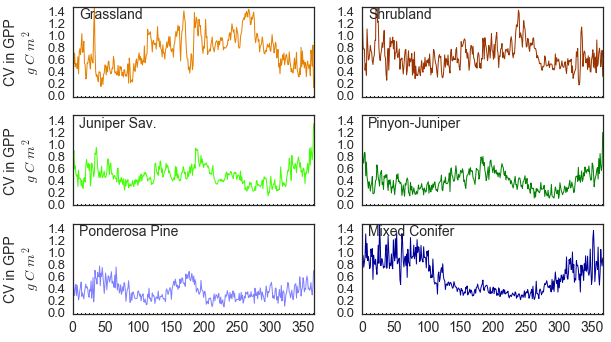

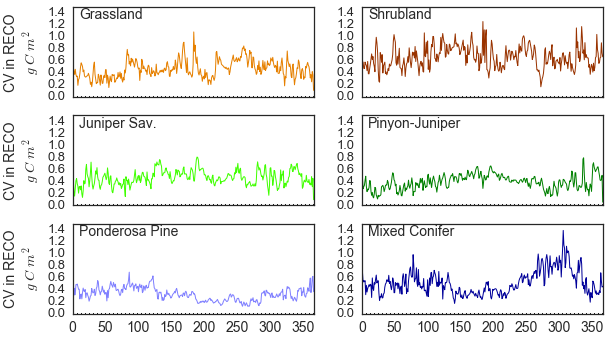

In [33]:
ylims = [ 0, 0.7 ]
fig1 = plt.figure(figsize=( 9.5, 5.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_multiyr_mean_sites( fc_clim_adj, 'allyr_cv', 'CV in NEE', 0.6, fig1,
                        ylims=ylims)
ylims = [ 0, 1.5 ]
fig2 = plt.figure(figsize=( 9.5, 5.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_multiyr_mean_sites( gpp_clim, 'allyr_cv', 'CV in GPP', 1.3, fig2,
                        ylims=ylims)
fig3 = plt.figure(figsize=( 9.5, 5.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_multiyr_mean_sites( re_clim, 'allyr_cv', 'CV in RECO', 1.3, fig3,
                        ylims=ylims)

## CV using allyear mean

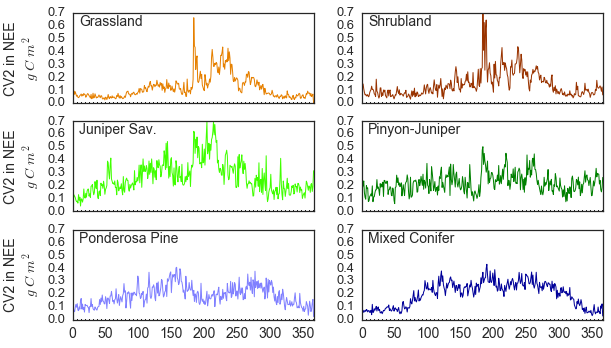

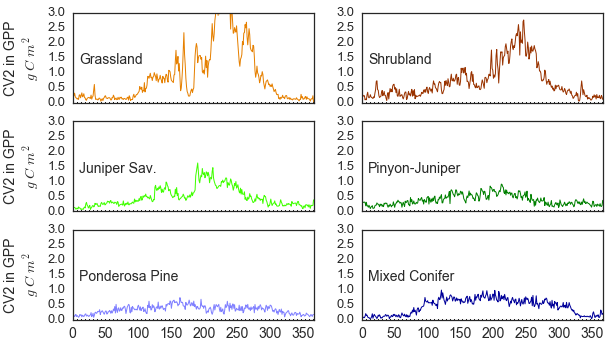

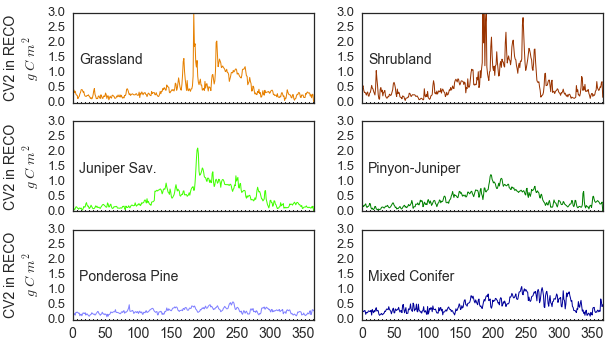

In [34]:
ylims = [ 0, 0.7 ]
fig1 = plt.figure(figsize=( 9.5, 5.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_multiyr_mean_sites( fc_clim_adj, 'allyr_cv2', 'CV2 in NEE', 0.6, fig1,
                        ylims=ylims)
ylims = [ 0, 3 ]
fig2 = plt.figure(figsize=( 9.5, 5.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_multiyr_mean_sites( gpp_clim, 'allyr_cv2', 'CV2 in GPP', 1.3, fig2,
                        ylims=ylims)
fig3 = plt.figure(figsize=( 9.5, 5.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_multiyr_mean_sites( re_clim, 'allyr_cv2', 'CV2 in RECO', 1.3, fig3,
                        ylims=ylims)